# **Mood-Driven Movie Recommender System Using NLP**

## Overview: Mood-Driven Movie Recommender System
This AI project explores the intersection of Natural Language Processing (NLP) and user sentiment analysis to create a personalized **Mood-Driven Movie Recommender System.** By leveraging the **DistilBERT** transformer model, fine-tuned on the **Emotion** dataset from the Hugging Face repository, this system classifies user-input text into one of six distinct emotions. Based on the identified mood, the system recommends a curated list of movies that align with the user's emotional state.

The core of the project involves training an NLP model to detect emotions from textual input and pairing those emotions with a database of movies. Using APIs like **The Movie Database (TMDb)**, the system retrieves movie recommendations dynamically, ensuring relevance and variety. This personalized approach enhances the user experience by making movie discovery more intuitive and emotionally aligned.

Key features of this project include:

* Emotion Classification: Utilizes a fine-tuned version of DistilBERT to identify emotions like "joy," "sadness," "anger," and more from text input.
  
* Movie Recommendation Engine: Maps detected emotions to movie genres or specific films, providing users with recommendations tailored to their mood.
  
* Streamlined Workflow: Implements tokenization, fine-tuning, and inference seamlessly using the Hugging Face library and PyTorch.
  
* Robust Methodology: Combines data preprocessing, hyperparameter optimization, and evaluation metrics to ensure a high-performing model.
  
This project demonstrates how AI can enhance personalized experiences by understanding user emotions and transforming them into actionable outputs. It also serves as a practical example of applying transformer-based NLP techniques in real-world scenarios.

In [ ]:
# Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [85]:
!pip install -U transformers

!pip install -U accelerate

!pip install -U datasets

!pip install -U bertviz

!pip install -U umap-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [86]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='EmoMovies')


# DATASET ANALYSIS

In [87]:
#loading emotion dataset
from datasets import load_dataset

emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

In [88]:
# Extract all rows from the 'train' dataset within the 'emotion' dictionary
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [89]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [90]:
# Create a new column 'label_name' in the DataFrame
# Map the integer labels in the 'label' column to their corresponding class names using the 'classes' list
df['label_name'] = df['label'].apply(lambda x: classes[x])

In [91]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [92]:
# prompt: Using dataframe df: pie chart

import altair as alt

# Count the occurrences of each label

label_counts = df['label_name'].value_counts().reset_index()
label_counts.columns = ['label_name', 'count']

# Create the pie chart

alt.Chart(label_counts).mark_arc().encode(
    theta='count',
    color='label_name',
    tooltip=['label_name', 'count']
).properties( title='Distribution of Labels')


alt.Chart(...)

In [93]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

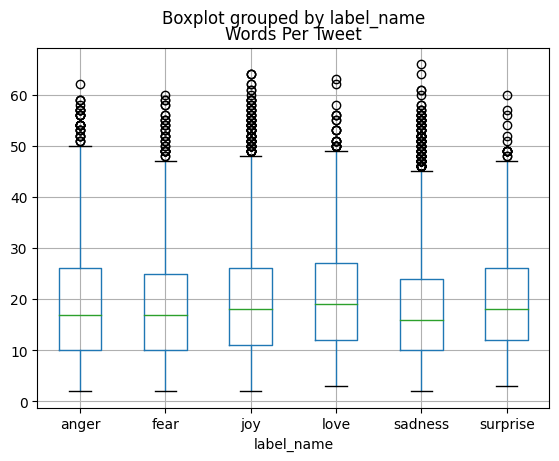

In [94]:
#create a boxplot

df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by='label_name')

# TEXT TO TOKENS CONVERSION

In [95]:
# Import the AutoTokenizer class from the Hugging Face transformers library
from transformers import AutoTokenizer

# Specify the model checkpoint name to be used
model_ckpt = "distilbert-base-uncased"

# Load the tokenizer associated with the specified model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [96]:
# sample text to be tokenized
text = "I love Artificial Intelligence!. Tokenization is awesome"

# Use the tokenizer to tokenize the input text
encoded_text = tokenizer(text)

print(encoded_text)

{'input_ids': [101, 1045, 2293, 7976, 4454, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [97]:
# Convert the tokenized IDs back to human-readable tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

print(tokens)

['[CLS]', 'i', 'love', 'artificial', 'intelligence', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [98]:
# Retrieve the vocabulary size and the maximum sequence length for the tokenizer
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

# TOKEIZATION OF EMOTION DATA

In [99]:
emotion.reset_format()

In [100]:
# Define a function to tokenize a batch of text samples
def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp
print(tokenize(emotion["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [101]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

In [102]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# MODEL BUILDING

In [103]:
# Tokenize the input text and return the result as PyTorch tensors
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2293,  7976,  4454,   999,  1012, 19204,  3989,  2003,
         12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [104]:
from transformers import AutoModel
import torch

# Load the pre-trained DistilBERT model
model = AutoModel.from_pretrained(model_ckpt)

In [105]:
# Perform inference without tracking gradients (no gradient updates for efficiency)
with torch.no_grad():

  outputs = model(**inputs)# Pass the tokenized inputs into the model

# Extract the last hidden states (output of the final transformer layer)
last_hidden_states = outputs.last_hidden_state

In [106]:
last_hidden_states.shape

torch.Size([1, 12, 768])

# FINE-TUNING TRANSFORMATION

In [107]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
from transformers import TrainingArguments
from transformers import TrainerCallback
batch_size = 64

model_name = "distilbert-finetuned-emotion"

class MetricLoggerCallback(TrainerCallback):
    def __init__(self):
        self.logs = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Capture metrics at each evaluation step
        self.logs.append(metrics)

# Initialize your custom callback
metric_logger = MetricLoggerCallback()

training_args = TrainingArguments(  output_dir=model_name,
                                    num_train_epochs=3,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy="steps",  # Evaluate after each epoch
                                    logging_dir='./logs',  # Directory to store logs
                                    logging_steps=10,  # Log metrics every 10 steps
                                    eval_steps=50,  # Evaluate every 50 steps
                                    save_steps=500,
                                    disable_tqdm=False)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [109]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc, "eval_f1": f1}


In [110]:
from transformers import Trainer
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer,
                  callbacks=[metric_logger],
                 )

# Train and capture metrics
train_output = trainer.train()

# The trainer.log_history contains all the training and evaluation logs
log_history = trainer.state.log_history

# Save the fine-tuned model and tokenizer
model.save_pretrained("/kaggle/working/distilbert-finetuned-emotion")
tokenizer.save_pretrained("/kaggle/working/distilbert-finetuned-emotion")


/tmp/ipykernel_30/1649244880.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1
50,1.235100,1.126178,0.580500,0.463158
100,0.699500,0.613193,0.819500,0.800543
150,0.383000,0.397127,0.878500,0.871704
200,0.272600,0.296404,0.908000,0.907074
250,0.268700,0.245938,0.921500,0.921557
300,0.218300,0.232283,0.926000,0.926281
350,0.179800,0.218914,0.928000,0.927772


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

('/kaggle/working/distilbert-finetuned-emotion/tokenizer_config.json',
 '/kaggle/working/distilbert-finetuned-emotion/special_tokens_map.json',
 '/kaggle/working/distilbert-finetuned-emotion/vocab.txt',
 '/kaggle/working/distilbert-finetuned-emotion/added_tokens.json',
 '/kaggle/working/distilbert-finetuned-emotion/tokenizer.json')

# MODEL EVALUATION

In [112]:
import pandas as pd

# Convert log history to a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)



In [113]:
# Filter logs to keep only evaluation metrics
eval_logs = log_history[log_history["eval_loss"].notnull()]  # Keeps rows where 'eval_loss' is logged

# Use the correct key based on the log inspection
if "eval_accuracy" in eval_logs.columns:
    eval_logs["validation_accuracy"] = eval_logs["eval_accuracy"]
else:
    print("Evaluation accuracy not found. Check compute_metrics output.")


/tmp/ipykernel_30/3496239930.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_logs["validation_accuracy"] = eval_logs["eval_accuracy"]


In [114]:
import pandas as pd
logs = metric_logger.logs
# Extract the metrics from the logs
metrics_df = pd.DataFrame(metric_logger.logs)

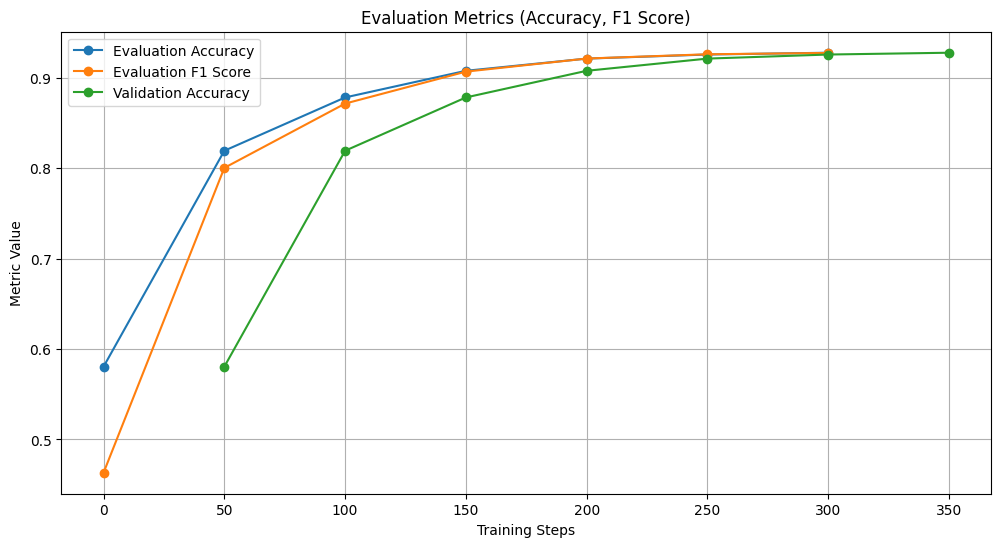

In [115]:
import matplotlib.pyplot as plt


steps_per_epoch = 50

# Adjust the x-axis index to represent actual steps
metrics_df['steps'] = metrics_df.index * steps_per_epoch  # Convert index to steps

# Plotting Evaluation Metrics: Loss, Accuracy, and F1 Score
plt.figure(figsize=(12, 6))


# Plotting eval_accuracy
plt.plot(metrics_df['steps'], metrics_df['eval_accuracy'], label='Evaluation Accuracy', marker='o')

# Plotting eval_f1
plt.plot(metrics_df['steps'], metrics_df['eval_f1'], label='Evaluation F1 Score', marker='o')

# Plot validation accuracy
plt.plot(eval_logs["step"], eval_logs["validation_accuracy"], label="Validation Accuracy", marker="o")

# Adding labels and title
plt.title('Evaluation Metrics (Accuracy, F1 Score)')
plt.xlabel('Training Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()


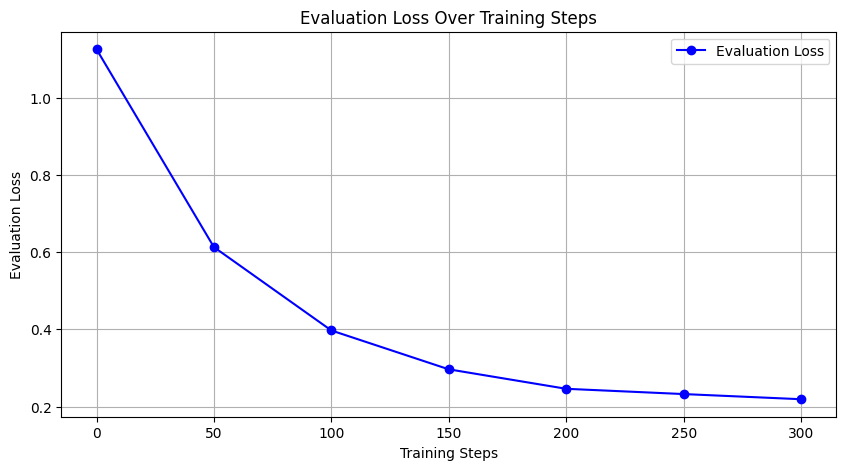

In [116]:
import matplotlib.pyplot as plt


steps_per_epoch = 50

# Adjust the x-axis index to represent actual steps
metrics_df['steps'] = metrics_df.index * steps_per_epoch  # Convert index to steps

# Plotting Evaluation Loss
plt.figure(figsize=(10, 5))

plt.plot(metrics_df['steps'], metrics_df['eval_loss'], label='Evaluation Loss', color='blue', marker='o')

# Adding labels and title
plt.title('Evaluation Loss Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [117]:
preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.21136806905269623,
 'test_eval_accuracy': 0.918,
 'test_eval_f1': 0.917445261851766,
 'test_runtime': 2.4156,
 'test_samples_per_second': 827.939,
 'test_steps_per_second': 6.624}

In [118]:
import numpy as np
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [119]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.93      0.94      0.93       695
           2       0.79      0.77      0.78       159
           3       0.94      0.92      0.93       275
           4       0.89      0.90      0.89       224
           5       0.78      0.68      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [120]:
#testing
text = 'i feel like fighting '
input_encoded = tokenizer(text, return_tensors='pt').to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]
     

(3, 'anger')

# MOVIE RECOMMENDER AND EMOTION CLASSIFIER INTERGRATION

In [121]:
import requests

# Example: Fetching movies based on a mood or emotion
API_KEY = "70becbd496d95c2def83c8d9f22588cb"  # Sign up on TMDb to get your API key

def get_movies_by_emotion(emotion):
    url = f"https://api.themoviedb.org/3/discover/movie?api_key={API_KEY}&with_genres={emotion}"
    response = requests.get(url)
    return response.json()['results']


In [122]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model_path = "/kaggle/working/distilbert-finetuned-emotion"  # Update the path if different
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Initialize the pipeline
emotion_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

label_to_emotion = {
    "LABEL_0": "sadness",
    "LABEL_1": "joy",
    "LABEL_2": "love",
    "LABEL_3": "anger",
    "LABEL_4": "fear",
    "LABEL_5": "surprise"
}

# Test the emotion classifier
def detect_mood(text):
    prediction = emotion_classifier(text)
    label = prediction[0]["label"]  # Get the label (e.g., LABEL_0)
    emotion = label_to_emotion.get(label, "unknown")  # Map to emotion
    return emotion  # Return the predicted mood label

# Example:
text_input = "I want to be surprised"
detected_emotion = detect_mood(text_input)
print(f"Detected Emotion: {detected_emotion}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Detected Emotion: surprise


In [124]:
import requests
from tabulate import tabulate
from IPython.display import display, HTML



def fetch_movies(emotion):
    """
    Fetch movie recommendations from TMDb based on emotion.
    """
    # Map emotions to genres or themes (this can be adjusted for better results)
    emotion_to_genre = {
        "joy": ([35], "Comedy"),          # Comedy
        "sadness": ([18], "Drama"),       # Drama
        "love": ([10749], "Romance"),     # Romance
        "anger": ([28], "Action"),        # Action
        "fear": ([27], "Horror"),         # Horror
        "surprise": ([53, 9648], "Mystery/Thriller")}  # Mystery and Thriller
    
    genre_id, genre_title = emotion_to_genre.get(emotion, (18, "Drama"))  # Default to Drama if emotion not mapped
    print(f"Fetching movies for emotion: '{emotion}' (Genre ID: {genre_id}, Genre Title: {genre_title})")  # Debugging line  # Default to Drama (ID 18) if emotion not mapped
    
    # TMDb API endpoint for discovering movies
    url = "https://api.themoviedb.org/3/discover/movie"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "sort_by": "popularity.desc",
        "with_genres": genre_id  # Adjust query based on genre
    }
    
    response = requests.get(url, params=params)
    print(f"API Response Status Code: {response.status_code}")  # Debugging line
    if response.status_code == 200:
        movies = response.json().get("results", [])
        print(f"Number of movies found: {len(movies)}")  # Debugging line
        return [{"title": movie["title"], "overview": movie["overview"]} for movie in movies[:20]]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return []

# Example:
# movies = fetch_movies(detected_emotion)
# print("Recommended Movies:")
# for movie in movies:
#     print(f"Title: {movie['title']}, Overview: {movie['overview']}")


In [125]:
import random
# Input text from the user
user_input = input("How are you feeling today? ")

# Step 1: Detect emotion (you need to define this function)
detected_emotion = detect_mood(user_input)
print(f"Detected Emotion: {detected_emotion}")

# Step 2: Fetch movies
recommended_movies = fetch_movies(detected_emotion)

# Step 3: Display the results
if recommended_movies:
    # Create a DataFrame from the movie data
    df = pd.DataFrame(recommended_movies)
    
    # Display the DataFrame as a table
    display(HTML(df.to_html(index=False)))
else:
    print("Sorry, no movie recommendations available at the moment.")

How are you feeling today?  I am so excited today


Detected Emotion: joy
Fetching movies for emotion: 'joy' (Genre ID: [35], Genre Title: Comedy)
API Response Status Code: 200
Number of movies found: 20


title,overview
Deadpool & Wolverine,"A listless Wade Wilson toils away in civilian life with his days as the morally flexible mercenary, Deadpool, behind him. But when his homeworld faces an existential threat, Wade must reluctantly suit-up again with an even more reluctant Wolverine."
Moana 2,"After receiving an unexpected call from her wayfinding ancestors, Moana journeys alongside Maui and a new crew to the far seas of Oceania and into dangerous, long-lost waters for an adventure unlike anything she's ever faced."
Red One,"After Santa Claus (codename: Red One) is kidnapped, the North Pole's Head of Security must team up with the world's most infamous bounty hunter in a globe-trotting, action-packed mission to save Christmas."
Despicable Me 4,"Gru and Lucy and their girls—Margo, Edith and Agnes—welcome a new member to the Gru family, Gru Jr., who is intent on tormenting his dad. Gru also faces a new nemesis in Maxime Le Mal and his femme fatale girlfriend Valentina, forcing the family to go on the run."
Sing: Thriller,"Buster Moon dreams up a star-studded spectacle set to Michael Jackson's ""Thriller"" in this animated short featuring characters from the hit ""Sing"" films."
The Bad Guys: Haunted Heist,The crafty Bad Guys crew embarks on a high-stakes Halloween heist to swipe a priceless amulet from a spooky mansion. What could go wrong?
Bad Boys: Ride or Die,"After their late former Captain is framed, Lowrey and Burnett try to clear his name, only to end up on the run themselves."
We Live in Time,"An up-and-coming chef and a recent divorcée find their lives forever changed when a chance encounter brings them together, in a decade-spanning, deeply moving romance."
Beetlejuice Beetlejuice,"After a family tragedy, three generations of the Deetz family return home to Winter River. Still haunted by Betelgeuse, Lydia's life is turned upside down when her teenage daughter, Astrid, accidentally opens the portal to the Afterlife."
IF,"After discovering she can see everyone's imaginary friends, a girl embarks on a magical adventure to reconnect forgotten imaginary friends with their kids."
